# coco分类数据集代码模块check

In [1]:
import sys
import os
sys.path.append(os.path.dirname("../"))

from dataset.coco import COCOClassificationDataset

In [2]:
dataset = COCOClassificationDataset(
    root_dir="/root/autodl-tmp/seat_dataset/chengdu_customer",
    ann_file="/root/detect_classify/predict_coco_correct.json",
    transform=None,
    min_bbox_area=5.0,
    target_categories= [
        '划伤', 
        '压痕', 
        '吊紧', 
        '异物外漏', 
        '折痕', 
        '抛线', 
        '拼接间隙', 
        '烫伤', 
        '破损', 
        '碰伤', 
        '红标签', 
        '线头', 
        '脏污', 
        '褶皱(T型)', 
        '褶皱（重度）', 
        '重跳针', 
        '背景'
    ]
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
print(f"数据集初始化完成:")
print(f"- 总共 {len(dataset.annotations)} 个标注框")
print(f"- {len(dataset.cat_ids)} 个类别")
print(f"- 类别名称: {[dataset.label_to_cat_name[i] for i in range(len(dataset.cat_ids))]}")

数据集初始化完成:
- 总共 585 个标注框
- 17 个类别
- 类别名称: ['划伤', '压痕', '吊紧', '异物外漏', '折痕', '抛线', '拼接间隙', '烫伤', '破损', '碰伤', '红标签', '线头', '脏污', '褶皱(T型)', '褶皱（重度）', '重跳针', '背景']


In [4]:
from collections import Counter

# 统计每个类别的数量
label_counter = Counter()
for ann in dataset.annotations:
    cat_id = ann['category_id']
    if cat_id in dataset.cat_ids:
        label = dataset.cat_id_to_label[cat_id]
        label_counter[label] += 1

print("每个类别的样本数量统计：")
for label in range(len(dataset.cat_ids)):
    name = dataset.label_to_cat_name[label]
    count = label_counter.get(label, 0)
    print(f"  类别: {name}，数量: {count}")


每个类别的样本数量统计：
  类别: 划伤，数量: 33
  类别: 压痕，数量: 10
  类别: 吊紧，数量: 0
  类别: 异物外漏，数量: 0
  类别: 折痕，数量: 1
  类别: 抛线，数量: 2
  类别: 拼接间隙，数量: 9
  类别: 烫伤，数量: 0
  类别: 破损，数量: 9
  类别: 碰伤，数量: 9
  类别: 红标签，数量: 0
  类别: 线头，数量: 27
  类别: 脏污，数量: 44
  类别: 褶皱(T型)，数量: 3
  类别: 褶皱（重度），数量: 156
  类别: 重跳针，数量: 0
  类别: 背景，数量: 221


数据集样本数量: 585
类别数量: 17
类别名称: ['划伤', '压痕', '吊紧', '异物外漏', '折痕', '抛线', '拼接间隙', '烫伤', '破损', '碰伤', '红标签', '线头', '脏污', '褶皱(T型)', '褶皱（重度）', '重跳针', '背景']

样本 0:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (10, 25)


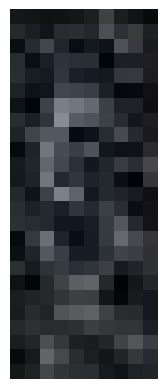


样本 1:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (106, 61)


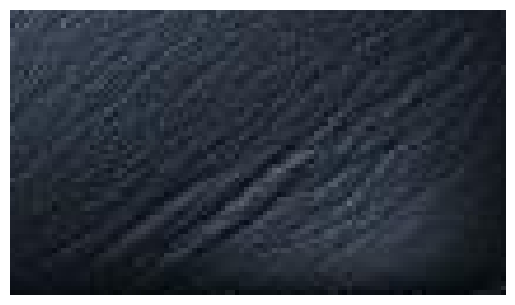


样本 2:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (166, 256)


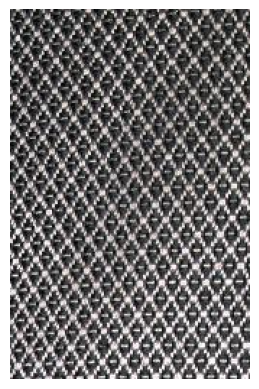


样本 3:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (7, 11)


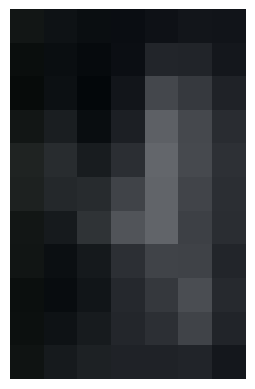


样本 4:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (91, 51)


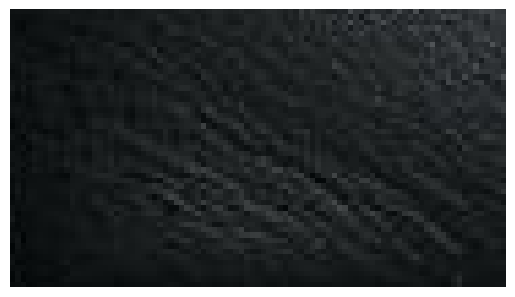


样本 5:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (23, 63)


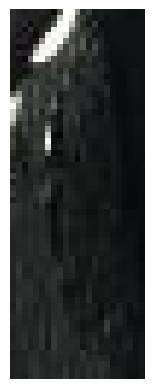


样本 6:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (98, 57)


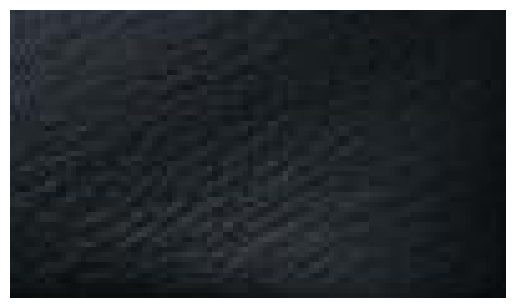


样本 7:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (17, 11)


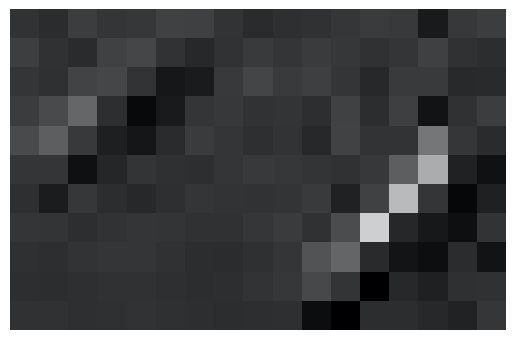


样本 8:
图片来源: predict
类别id: 16
类别名称: 背景
图片尺寸: (66, 80)


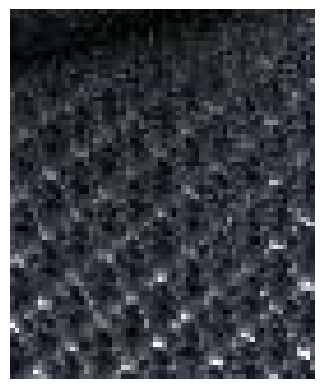

KeyError: 8

In [7]:
# 检查数据集加载情况
print(f"数据集样本数量: {len(dataset)}")
print(f"类别数量: {dataset.get_num_classes()}")
print(f"类别名称: {dataset.get_class_names()}")

# 设置matplotlib显示中文字体（自动降级，避免SimHei缺失报错）
import matplotlib.pyplot as plt

for i in range(100):
    img, label, info = dataset[i]
    print(f"\n样本 {i}:")
    print(f"图片来源: {info['annotation_source']}")
    print(f"类别id: {label}")
    print(f"类别名称: {info['category_name']}")
    # print(info)
    if hasattr(img, 'size'):
        if callable(img.size):
            img_size = img.size
        else:
            img_size = img.size
    elif hasattr(img, 'shape'):
        img_size = img.shape
    else:
        img_size = "未知"
    print(f"图片尺寸: {img_size}")
    plt.imshow(img)
    # plt.title(f"类别: {info['category_name']}  尺寸: {img_size}")
    plt.axis('off')
    plt.show()
